The aim of this Notebook is to create a code that calculate simulations for the pricicng and hedging of derivatives defined by a Cox-Ross-Rubinstien (CRR) model

### Parameters of the model

The parameters of the models are the following:

In [22]:
import os
import numpy as np
import scipy as scp
#import pylab
import math
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx 
r = 0.05   # The interest rate of the riskless bond
p = 0.5   # The probability for the price at each period to go upwarwd
q = 1.0-p # The probability for the price at each period to go downwarwd
u = 2.0   # The level of increase of the price
d = 0.5   # The level of decrease of the price
T = 5     # Number of periods in the model
S0 = 100  # Value of the risky asset at time 0
p_star = (1+r-d)/(u-d)

### The non-arbitrage condition

##### 1) Recall the non-arbitrage conditon and create a test command which prints an error message in case in is not satisfied

The non-arbitrage condition is: 
$d < 1+r < u$. Write a code below which tests the non-arbitrage condition and define the $p^\ast$

### Simulating sample paths of the risky asset

In [23]:
M = 10    # The number of simulated sample paths
S = np.zeros((M,T+1))

We create and initialize the first valuer of the stock $S$

In [24]:
start = np.zeros(M)
for i in range(0,M):
    start[i]=S0
S[:,0]=start

##### 2) Simulate $M$ paths of the stock $S$

In [25]:
B = np.random.binomial(1,p,T+1) # We simulate all the Bernouilli random variables

In [26]:
def transform(B): # Transform a vector of O and 1 into a vector of u and d's
    temp1 = np.size(B)
    up_and_down = np.zeros(temp1)
    for i in range(0,temp1):
        if B[i]==1:
            up_and_down[i]=u
        else:
            up_and_down[i]=d
    return up_and_down

### Representation using graphs (Binary trees)

In [27]:
def binomial_grid(n,s0):
    G=nx.Graph() 
    for i in range(0,n):
        j=-i+1
        while (j<i+2):
            G.add_edge((i,j),(i+1,j+1),weight=0.0)
            G.add_edge((i,j),(i+1,j-1),weight=0.0)
            j=j+2
    
    j=1
    for i in range(0,n):
        r=np.random.binomial(1,p,1)
        if r >0:
            G.add_edge((i,j),(i+1,j+1),weight=1.0)
            j=j+1
        else:
            G.add_edge((i,j),(i+1,j-1),weight=1.0)
            j=j-1
    
    posG={}
    lab={}
    for node in G.nodes():
        posG[node]=(node[0],node[1])
        if node[0]==0:
            lab[node]=s0
        i=node[0]
        j=node[1]
        if j>1:
            lab[node]=s0*(u**(j-1))
        elif j==1:
            lab[node]=s0
        else:
            lab[node]=s0*(d**(1-j))
    elarge=[(a,b) for (a,b,c) in G.edges(data=True) if c['weight'] >0.5]
    esmall=[(a,b) for (a,b,c) in G.edges(data=True) if c['weight'] <=0.5]
    nx.draw_networkx_edges(G,posG,edgelist=elarge,edge_color='blue',width=2)
    nx.draw_networkx_edges(G,posG,edgelist=esmall,style='dashed')
    nx.draw_networkx_labels(G,posG,lab,font_size=15,font_family='sans-serif')
    plt.show()

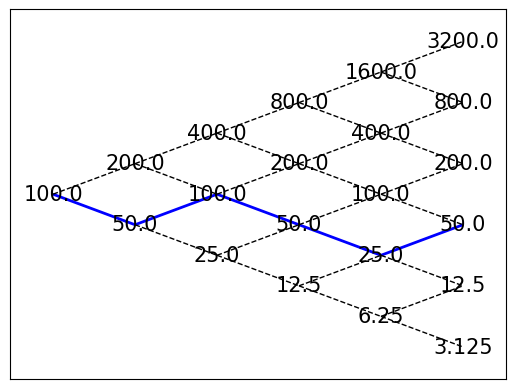

In [28]:
binomial_grid(5,100.0)

### Pricing

##### Pricing of European Financial claims on the Cox-Ross-Rubinstien model

The aim of this section is to write a function "Price" which computes the (arbitrage) price at any time of a contract whose payoff is given by a mapping $g_T$ using the Dynamic Programming Principle as in Theorem 6.2.1.

we start with a plotting function for a Binary tree

In [29]:
def plot_tree(g):
    pos={}
    lab={}
    
    for n in g.nodes():
        pos[n]=(n[0],n[1])
        lab[n]=float(int(g.nodes[n]['value']*1000))/1000 # This is just to print only with 10^-2 precision
    
    elarge=g.edges(data=True)
    nx.draw_networkx_edges(g,pos,edgelist=elarge)
    nx.draw_networkx_labels(g,pos,lab,font_size=15,font_family='sans-serif')
    plt.show()   

We construct the graph of prices

In [30]:
def graph_stock():
    S=nx.Graph()
    for i in range(0,T):
        j=-i+1
        while (j<i+2):
            S.add_edge((i,j),(i+1,j+1))
            S.add_edge((i,j),(i+1,j-1))
            j=j+2
            
    for n in S.nodes():
        
        if n[0]==0:
            S.nodes[n]['value']=S0
        i=n[0]
        j=n[1]
        if j>1:
            S.nodes[n]['value'] = S0*(u**(j-1))
        elif j==1:
            S.nodes[n]['value'] = S0
        else:
            S.nodes[n]['value'] = S0*(d**(1-j))
    return S

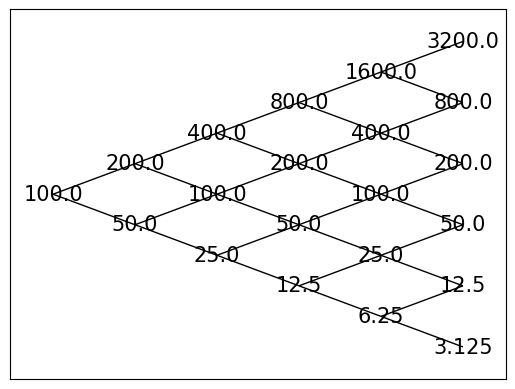

In [31]:
S=nx.Graph()
S =graph_stock()
plot_tree(S)

##### 3) Compute the price of a European Call Option

In [32]:
def European_call(x,K):
        return np.maximum(x-K,0.0)

In [33]:
def compute_European_Call_prices(K):

    g = nx.Graph()
    price = nx.Graph()
    
    S = nx.Graph()
    
    S = graph_stock()

    for i in range(0,T):
            j=-i+1
            while (j<i+2):
                g.add_edge((i,j),(i+1,j+1))
                g.add_edge((i,j),(i+1,j-1))
                price.add_edge((i,j),(i+1,j+1))
                price.add_edge((i,j),(i+1,j-1))
                j=j+2

    for n in S.nodes():
        if n[0]==T:
            g.nodes[n]['value'] = European_call(S.nodes[n]['value'],K)
            price.nodes[n]['value'] = European_call(S.nodes[n]['value'],K)
    
    i=T-1
    while i>=0:
        j=-i+1
        while j<i+2:
            g.nodes[(i,j)]['value'] = g.nodes[(i+1,j+1)]['value']*p_star + g.nodes[(i+1,j-1)]['value']*(1.0-p_star)
            price.nodes[(i,j)]['value'] = g.nodes[(i,j)]['value']*((1.0+r)**(i-T))
            j=j+2
        i=i-1
        
    return price

Computation the price of a European Call option

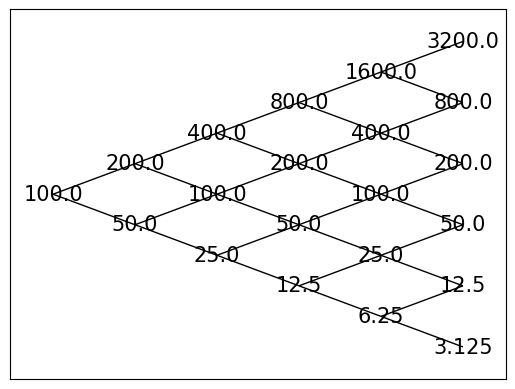

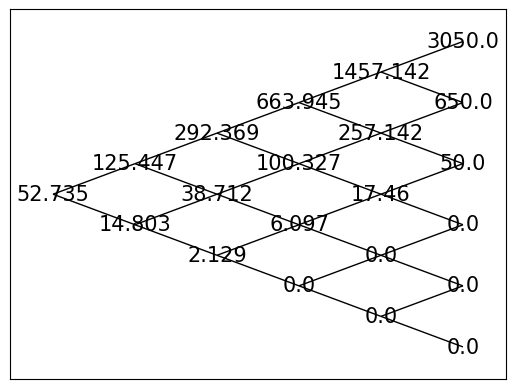

Value of the price at time 0 of the European Call option with strike  150  =  52.735915428700615


In [34]:
price = nx.Graph()
S = nx.Graph()
S = graph_stock()

K=0.0

K = input("Enter the value of the strike K : ")

price_Call = compute_European_Call_prices(float(K))

plot_tree(S)
plot_tree(price_Call)

print('Value of the price at time 0 of the European Call option with strike ',K,' = ',price_Call.nodes[(0,1)]['value'])

##### 4) Compute the price of a European Put Option

In [35]:
def compute_European_Put_prices(K):

    Put = nx.Graph()
    
    S = nx.Graph()
    S = graph_stock()
    
    Call = nx.Graph()
    Call = compute_European_Call_prices(K)

    for i in range(0,T):
            j=-i+1
            while (j<i+2):
                Put.add_edge((i,j),(i+1,j+1))
                Put.add_edge((i,j),(i+1,j-1))
                j=j+2
    
    for n in S.nodes():
        if n[0]==T:
            Put.nodes[n]['value'] = European_call(K,S.nodes[n]['value'])    
    i=T-1
    while i>=0:
        j=-i+1
        while j<i+2:
            ####  Fill Below ####
            #Put.nodes[(i,j)]['value'] = ???
            j=j+2
        i=i-1
        
    return Put

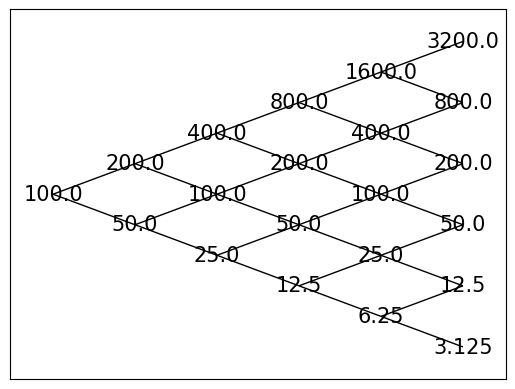

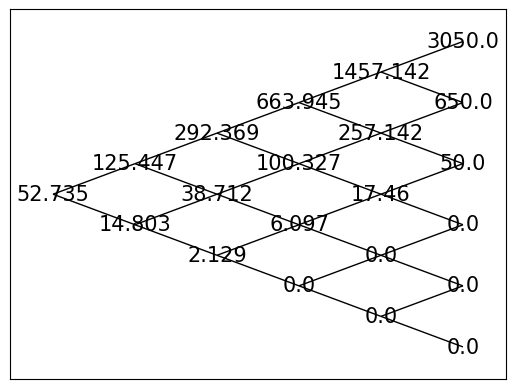

KeyError: 'value'

In [36]:
S = nx.Graph()
S = graph_stock()

price_Put = nx.Graph()
price_Call =nx.Graph()

K=0.0

K = input("Enter the value of the strike K : ")

price_Call = compute_European_Call_prices(float(K))

price_Put = compute_European_Put_prices(float(K))

plot_tree(S)
plot_tree(price_Call)
plot_tree(price_Put)

##### 5) Complete the codes above to compute a hedging strategy and simulate the associated wealth processes

In [37]:
def compute_European_Call_strategy(K):

    Call = nx.Graph()
    Call = compute_European_Call_prices(float(K))

    S = nx.Graph()
    S = graph_stock()
    
    Strat_Call = nx.Graph()
    
    for i in range(0,T):
            j=-i+1
            while (j<i+2):
                Strat_Call.add_edge((i,j),(i+1,j+1))
                Strat_Call.add_edge((i,j),(i+1,j-1))
                j=j+2
    
    for n in S.nodes():
        if n[0]==T:
            Strat_Call.nodes[n]['value'] = 0.0    
    i=T-1
    while i>=0:
        j=-i+1
        while j<i+2:
             ####  Fill Below ####
            # Strat_Call.nodes[(i,j)]['value'] = ???
            j=j+2
        i=i-1
        
    return Strat_Call

In [38]:
def compute_European_Put_strategy(K):

    Put = nx.Graph()
    Put = compute_European_Put_prices(float(K))

    S = nx.Graph()
    S = graph_stock()
    
    Strat_Put = nx.Graph()
    
    for i in range(0,T):
            j=-i+1
            while (j<i+2):
                Strat_Put.add_edge((i,j),(i+1,j+1))
                Strat_Put.add_edge((i,j),(i+1,j-1))
                j=j+2
    
    for n in S.nodes():
        if n[0]==T:
            Strat_Put.nodes[n]['value'] = 0.0    
    i=T-1
    while i>=0:
        j=-i+1
        while j<i+2:
             ####  Fill Below ####
            #Strat_Put.nodes[(i,j)]['value'] = ???
            j=j+2
        i=i-1
        
    return Strat_Put

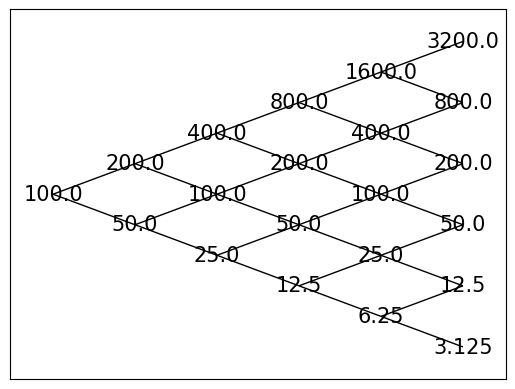

KeyError: 'value'

In [39]:
# We plot the trees of the hedging strategies
S = nx.Graph()
S = graph_stock()

price_Put = nx.Graph()

K=0.0

K = input("Enter the value of the strike K : ")

Strat_Call = compute_European_Call_strategy(float(K))

Strat_Put = compute_European_Put_strategy(float(K))

plot_tree(S)
plot_tree(Strat_Call)
plot_tree(Strat_Put)

In [ ]:
def compute_European_Call_optimal_Wealth(K):

    Call = nx.Graph()
    Call = compute_European_Call_prices(float(K))

    S = nx.Graph()
    S = graph_stock()
    
    Strat_Call = nx.Graph()
    Strat_Call = compute_European_Call_strategy(float(K))
    
    Wealth = nx.Graph()
    
    #Initialization of the tree wealth
    Wealth = Call 
    
    for i in range(0,T):
        j=-i+1
        while (j<i+2):
            Wealth.add_edge((i,j),(i+1,j+1))
             ####  Fill Below ####
            # Wealth.nodes[(i+1,j+1)]['value'] = ???

            Wealth.add_edge((i,j),(i+1,j-1))
            ####  Fill Below ####
            # Wealth.nodes[(i+1,j-1)]['value'] = ???
            j=j+2
        
    return Wealth

In [ ]:
def compute_European_Put_optimal_Wealth(K):

    Call = nx.Graph()
    Call = compute_European_Put_prices(float(K))

    S = nx.Graph()
    S = graph_stock()
    
    Strat_Put = nx.Graph()
    Strat_Put = compute_European_Put_strategy(float(K))
    
    Wealth = nx.Graph()
    
    #Initialization of the tree wealth
    Wealth = Put 
    
    for i in range(0,T):
        j=-i+1
        while (j<i+2):
            Wealth.add_edge((i,j),(i+1,j+1))
            Wealth.node[(i+1,j+1)]['value'] = Strat_Put.node[(i,j)]['value']*S.node[(i+1,j+1)]['value'] + (Wealth.node[(i,j)]['value'] - Strat_Put.node[(i,j)]['value']*S.node[(i,j)]['value'])*(1+r) 

            Wealth.add_edge((i,j),(i+1,j-1))
            Wealth.node[(i+1,j-1)]['value'] = Strat_Put.node[(i,j)]['value']*S.node[(i+1,j-1)]['value'] + (Wealth.node[(i,j)]['value'] - Strat_Put.node[(i,j)]['value']*S.node[(i,j)]['value'])*(1+r) 
            j=j+2
        
    return Wealth

In [ ]:
# We plot the trees of the wealths associated to the hedging strategies of the Call and the Put
price_Put = nx.Graph()

S = nx.Graph()
S = graph_stock()

K=0.0

K = input("Enter the value of the strike K : ")

Wealth_Call = compute_European_Call_optimal_Wealth(float(K))

Strat_Put = compute_European_Put_strategy(float(K))

plot_tree(S)
plot_tree(Wealth_Call)
plot_tree(Strat_Put)

##### 6) We now deal with the case of American Options

We admit that the price at a given time $t$ of an American Option with respect to the family of discounted payoffs $(\tilde G_t:=(1+r)^{-t} g_t^{Europ}(S_t))_t$ is given by:
$$ \nu_t = \max\left(\tilde G_t,\mathbb{E}^{\mathbb{P}^\ast}[\nu_{t+1}\vert \mathcal{F}_t]\right), \quad \nu_T:=\tilde G_T. $$

Deduce that at any time $t$, $\nu_t = f_t^{Amer}(S_t)$ with
$$ f_t^{Amer}(x):= \max\left((1+r)^{-t} g_t^{Europ}(x),f_{t+1}^{Amer}(x u) p^\ast + f_{t+1}^{Amer}(x d) (1-p^\ast)\right), \quad f_T^{Amer}(x):=g_T^{Europ}(x).$$

Write a code to compute the graph of an American Call Option and compare it with the price of the European Call Option

In [ ]:
def compute_American_Call_Snell(K):
    
    Snell = nx.Graph()
    
    S = nx.Graph()
    
    S = graph_stock()
    
    for i in range(0,T):
        j=-i+1
        while (j<i+2):
            Snell.add_edge((i,j),(i+1,j+1))
            Snell.add_edge((i,j),(i+1,j-1))
            j=j+2
            
    for n in S.nodes():
        if n[0]==T:
            Snell.nodes[n]['value'] = European_call(S.nodes[n]['value'],float(K))*(1.0+r)**(-T) 
    
    i=T-1
    while i>=0:
        j=-i+1
        while j<i+2:
            temp = Snell.nodes[(i+1,j+1)]['value']*p_star + Snell.nodes[(i+1,j-1)]['value']*(1.0-p_star)
            ####  Fill Below ####
            # Snell.nodes[(i,j)]['value'] = ???
            j=j+2
        i=i-1
        
    return Snell

In [ ]:
S = nx.Graph()
S = graph_stock()

Snell_American_Call = nx.Graph()

price_European_Call = nx.Graph()

K=0.0

K = input("Enter the value of the strike K : ")

price_European_Call = compute_European_Call_prices(float(K))

Snell_American_Call = compute_American_Call_Snell(float(K))

plot_tree(S)
plot_tree(price_European_Call)
plot_tree(Snell_American_Call)

American Put Option

In [ ]:
def compute_American_Put_Snell(K):
    
    Snell = nx.Graph()
    
    S = nx.Graph()
    
    S = graph_stock()
    
    for i in range(0,T):
        j=-i+1
        while (j<i+2):
            Snell.add_edge((i,j),(i+1,j+1))
            Snell.add_edge((i,j),(i+1,j-1))
            j=j+2
            
    for n in S.nodes():
        if n[0]==T:
            Snell.nodes[n]['value'] = European_call(float(K),S.nodes[n]['value'])*(1.0+r)**(-T) 
    
    i=T-1
    while i>=0:
        j=-i+1
        while j<i+2:
            temp = Snell.nodes[(i+1,j+1)]['value']*p_star + Snell.nodes[(i+1,j-1)]['value']*(1.0-p_star)
            Snell.nodes[(i,j)]['value'] = np.maximum(European_call(float(K),S.nodes[(i,j)]['value'])*(1.0+r)**(-i),temp)
            j=j+2
        i=i-1
        
    return Snell

In [ ]:
S = nx.Graph()
S = graph_stock()

Snell_American_Put = nx.Graph()

price_European_Put = nx.Graph()

K=0.0

K = input("Enter the value of the strike K : ")

price_European_Put = compute_European_Put_prices(float(K))

Snell_American_Put = compute_American_Put_Snell(float(K))

plot_tree(S)
plot_tree(price_European_Put)
plot_tree(Snell_American_Put)